In [2]:
! pip install sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 2.2 MB/s 
     |████████████████████████████████| 5.3 MB 16.6 MB/s 
     |████████████████████████████████| 1.3 MB 52.1 MB/s 
     |████████████████████████████████| 163 kB 70.9 MB/s 
     |████████████████████████████████| 7.6 MB 50.3 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=d59cc38c9bf477caa682e513e08de71e83e985e53a76a1c36dd89db4bec80f1a
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers


In [3]:
import pandas as pd
from scipy import spatial
import string
from sentence_transformers import SentenceTransformer
from sklearn.metrics import f1_score, precision_score, recall_score

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
path = '/content/drive/MyDrive/ИТМО/train.csv'
df = pd.read_csv(path, index_col='pair_id')
df.head()

,name_1,name_2,is_duplicate
pair_id,,,
1,Iko Industries Ltd.,"Enormous Industrial Trade Pvt., Ltd.",0
2,Apcotex Industries Ltd.,Technocraft Industries (India) Ltd.,0
3,"Rishichem Distributors Pvt., Ltd.",Dsa,0
4,Powermax Rubber Factory,Co. One,0
5,Tress A/S,Longyou Industries Park Zhejiang,0


# Proccessing

In [6]:
def preprocess_data(company_name: str, make_translation: bool = True):

    company_name = company_name.translate(str.maketrans('', '', string.punctuation))

    common_words = ['ltd', 'co', 'inc', 'international', 'industries', 'air', 'lines', 'trading',
                    'logistics', 'products', 'industrial', 'corp', 'corporation', 'trade', 'group',
                    'industry', 'industria', 'comercio', 'global']

    company_name_list = [name.lower() for name in company_name.split()]
    company_name_rdy_list = []

    for word in company_name_list:
        if word not in common_words:
            company_name_rdy_list.append(word)

    return ' '.join(company_name_rdy_list)


df['name_1'] = df['name_1'].apply(preprocess_data)
df['name_2'] = df['name_2'].apply(preprocess_data)

In [7]:
df.head()

,name_1,name_2,is_duplicate
pair_id,,,
1,iko,enormous pvt,0
2,apcotex,technocraft india,0
3,rishichem distributors pvt,dsa,0
4,powermax rubber factory,one,0
5,tress as,longyou park zhejiang,0


## BERT

In [8]:
model = SentenceTransformer('bert-base-nli-mean-tokens')

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.95k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/399 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [11]:
name_1_encoded = model.encode(df['name_1'].tolist(), show_progress_bar=True, device='cuda')

Batches:   0%|          | 0/15557 [00:00<?, ?it/s]

In [15]:
name_2_encoded = model.encode(df['name_2'].tolist(), show_progress_bar=True, device='cuda')

Batches:   0%|          | 0/15557 [00:00<?, ?it/s]

In [16]:
name_1_encoded_new = []
name_2_encoded_new = []
for i in range(len(name_2_encoded)):
  name_1_encoded_new.append(name_1_encoded[i])
  name_2_encoded_new.append(name_2_encoded[i])

df['name_1_encoded'] = name_1_encoded_new
df['name_2_encoded'] = name_2_encoded_new

In [19]:
def save_feather(df, path="dummy.feather"):
    df = df.reset_index()
    df.to_feather(path)
    
save_feather(df, '/content/drive/MyDrive/ИТМО/df_vec.feather')

## Metrics

In [23]:
df.head()

,name_1,name_2,is_duplicate,name_1_encoded,name_2_encoded
pair_id,,,,,
1,iko,enormous pvt,0,"[-0.073362514, -0.18262497, 1.6535435, 0.24685...","[0.19251333, -0.5596863, 1.0955981, 0.46011654..."
2,apcotex,technocraft india,0,"[-0.18219618, 0.18347034, 1.744427, 0.5191355,...","[0.33033672, 0.35635394, 1.2154638, 0.19013697..."
3,rishichem distributors pvt,dsa,0,"[0.60298944, -0.22483012, 1.6071658, 0.4184533...","[-0.2069592, -0.37461904, 1.9735248, 0.6094535..."
4,powermax rubber factory,one,0,"[0.8159304, 0.19555126, 0.34510943, 0.08463026...","[-0.301013, -0.4847614, 1.9171683, 0.5354256, ..."
5,tress as,longyou park zhejiang,0,"[0.25681272, -0.19096059, 2.099755, 0.5939899,...","[0.47812915, -0.7191742, 0.9347343, 0.7729282,..."


In [27]:
df['cosine_similarity'] = df.apply(lambda x: 1 - spatial.distance.cosine(x['name_1_encoded'], x['name_2_encoded']), axis=1)

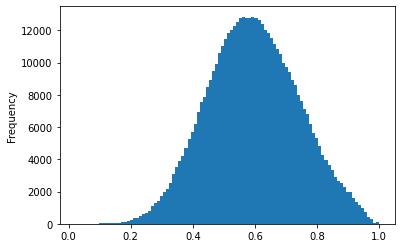

In [29]:
df['cosine_similarity'].plot(kind='hist', bins=100);

In [33]:
df.is_duplicate.value_counts()

0    494161
1      3658
Name: is_duplicate, dtype: int64

In [34]:
3658/(3658+494161)

0.007348052203712594

In [71]:
def get_metrics(df, col, THRESHOLD):
  df[col] = 0
  df.loc[df['cosine_similarity'] > THRESHOLD, col] = 1

  y_true = df['is_duplicate']
  y_pred = df[col]

  print('THRESHOLD - ', THRESHOLD)
  print('f1_score - ', f1_score(y_true, y_pred))
  print('precision_score - ', precision_score(y_true, y_pred))
  print('recall_score - ', recall_score(y_true, y_pred))

In [82]:
for i in range(900, 999, 2):
  tr = i/1000
  get_metrics(df, 'is_duplicated_model', tr)

THRESHOLD -  0.9
f1_score -  0.07824652368607118
precision_score -  0.05490023150700033
recall_score -  0.13613996719518862
THRESHOLD -  0.902
f1_score -  0.07889833940866749
precision_score -  0.056060780476574194
recall_score -  0.13313285948605796
THRESHOLD -  0.904
f1_score -  0.07821416582745888
precision_score -  0.056430128360377814
recall_score -  0.1273920174958994
THRESHOLD -  0.906
f1_score -  0.0793747286148502
precision_score -  0.05816469390352552
recall_score -  0.1249316566429743
THRESHOLD -  0.908
f1_score -  0.080806262935301
precision_score -  0.0602280348759222
recall_score -  0.122744669218152
THRESHOLD -  0.91
f1_score -  0.08130988929202716
precision_score -  0.0616274150331406
recall_score -  0.11946418808091853
THRESHOLD -  0.912
f1_score -  0.08396872888717305
precision_score -  0.06489631508279875
recall_score -  0.11891744122471296
THRESHOLD -  0.914
f1_score -  0.08286027288118712
precision_score -  0.06517311608961303
recall_score -  0.11372334609075997
TH

Best score

f1_score -  0.10063176895306859

precision_score -  0.28811369509043927

recall_score -  0.06096227446692182